Analyse des flux métaboliques sur un modèle genome-scale avec MetExplore 

Étape 1 : Créer le modèle à partir du SBML

In [ ]:
import cobra
from cobra.io import read_sbml_model
import pandas as pd

cobra.__version__

In [ ]:
from cobra.io import read_sbml_model
model = read_sbml_model("MODEL.xml")
model

Model does not contain SBML fbc package information.
SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Adding exchange reaction EX_pa141_b with default bounds for boundary metabolite: pa141_b.
Adding exchange reaction EX_glu_D_b with default bounds for boundary metabolite: glu_D_b.
Adding exchange reaction EX_34dhphe_b with default bounds for boundary metabolite: 34dhphe_b.
Adding exchange reaction EX_12dgr160_b with default bounds for boundary metabolite: 12dgr160_b.
Adding exchange reaction EX_RSc3220_b with default bounds for boundary metabolite: RSc3220_b.
Adding exchange reaction EX_fusa_b with default bounds for boundary metabolite: fusa_b.
Adding exchange reaction EX_RipAX2_b with default bounds for boundary metabolite: RipAX2_b.
Adding exchange reaction EX_RSp1071_b with default bounds for boundary metabolite: RSp1071_b.
Adding exchange reaction EX_acfv_b with default bounds for bo

Étape 2 : Nombre de réactions, métabolites, gènes

In [4]:
print(model)
print(f"Réactions : {len(model.reactions)}")
print(f"Métabolites : {len(model.metabolites)}")
print(f"Gènes : {len(model.genes)}")

MODEL1612020000
Réactions : 3097
Métabolites : 2574
Gènes : 2219


Étape 3 : Définir la réaction BIOMASS comme objectif

In [6]:
# Afficher les 5 premières réactions pour identifier la BIOMASS
list(model.reactions)[:5]

# Supposons que la réaction de biomasse s'appelle "BIOMASS"
model.objective = "BIOMASS"

print("Objectif défini :", model.objective)

Objectif défini : Maximize
1.0*BIOMASS - 1.0*BIOMASS_reverse_69053


In [7]:
solution = model.optimize()
print("Taux de croissance :", solution.objective_value)

Taux de croissance : 1000.0


Étape 4 : Mettre à 0 le lower bound de toutes les réactions d’échange

In [8]:
for rxn in model.exchanges:
    rxn.lower_bound = 0

Étape 5 : Fixer les bounds pour certains métabolites

In [10]:
metabolites = ["h2o_b","h_b","k_b","pi_b","na1_b","nh4_b","so4_b",
               "mg2_b","cl_b","fe2_b","fe3_b","cobalt2_b","mn2_b","mobd_b","o2_b","co2_b"]

for met in metabolites:
    rxn_id = "EX_" + met
    if rxn_id in model.reactions:
        model.reactions.get_by_id(rxn_id).lower_bound = -1000
        model.reactions.get_by_id(rxn_id).upper_bound = 1000

Étape 6 : 
Question : Pourquoi met-on le flux lower bound à 0 pour toutes les réactions d’échange 
sauf pour les réactions faisant intervenir certains métabolites ?

Réponse :
On bloque l’importation par défaut pour tous les métabolites (lower bound = 0) pour contrôler exactement ce qui peut entrer dans la cellule, puis on autorise certains métabolites essentiels à être importés (comme H2O, ions, nutriments), sinon la cellule pourrait "importer" tout librement, ce qui n’est pas réaliste biologiquement.


Étape 7 : Fixer flux spécifiques

In [11]:
# NGAME = 8.39
if "NGAME" in model.reactions:
    model.reactions.NGAME.lower_bound = 8.39
    model.reactions.NGAME.upper_bound = 8.39

# FEOXpp = 0
if "FEOXpp" in model.reactions:
    model.reactions.FEOXpp.lower_bound = 0
    model.reactions.FEOXpp.upper_bound = 0

Étape 8 : Calculer le taux de croissance et métabolites importés / excrétés

In [17]:
# Optimisation du modèle
solution = model.optimize()

# Taux de croissance (valeur de l'objectif, BIOMASS)
taux_croissance = solution.objective_value
print("Taux de croissance :", taux_croissance)
# Créer deux listes pour imports et exports
imports = []
exports = []

for rxn in model.exchanges:
    flux = solution.fluxes[rxn.id]
    if flux < 0:
        imports.append((rxn, flux))  # on stocke l'objet Reaction
    elif flux > 0:
        exports.append((rxn, flux))

# Affichage
print("Métabolites importés (avec flux) :")
for rxn, flux in imports:
    print(rxn.id, flux, [met.id for met in rxn.metabolites])

print("\nMétabolites excrétés (avec flux) :")
for rxn, flux in exports:
    print(rxn.id, flux, [met.id for met in rxn.metabolites])  

Taux de croissance : 24.935229494625936
Métabolites importés (avec flux) :
EX_pi_b -20.893079182173313 ['pi_b']
EX_cobalt2_b -0.006183936914667232 ['cobalt2_b']
EX_k_b -4.86718225074452 ['k_b']
EX_so4_b -31.420172032137614 ['so4_b']
EX_nh4_b -252.69062347100635 ['nh4_b']
EX_mobd_b -0.0032166446048067453 ['mobd_b']
EX_fe2_b -52.86334419528399 ['fe2_b']
EX_mg2_b -0.21631311586588 ['mg2_b']
EX_cl_b -0.12978786951952803 ['cl_b']
EX_co2_b -1000.0 ['co2_b']
EX_mn2_b -0.017230243580786522 ['mn2_b']
EX_h2o_b -433.51921840422347 ['h2o_b']

Métabolites excrétés (avec flux) :
EX_ohr_b 185.90508973415837 ['ohr_b']
EX_meoh_b 4.987045898925188e-05 ['meoh_b']
EX_o2s_b 12.1811432463569 ['o2s_b']
EX_o2_b 1000.0 ['o2_b']
EX_5mtr_b 0.1681631877117573 ['5mtr_b']
EX_4hba_b 0.005560556177301582 ['4hba_b']
EX_fe3_b 52.65755374626482 ['fe3_b']
EX_amob_b 4.987045898925187e-05 ['amob_b']
EX_h2s_b 27.462377601062112 ['h2s_b']


Étape 9 : Fixer flux expérimentaux

In [18]:
exp_fluxes = {
    "EX_glu_L_b": -8.25,
    "EX_3ohpame_b": 1.5E-4,
    "EX_EPS_b": 0.0062,
    "EX_ptrc_b": 0.28,
    "EX_Tek_28kd_b": 2.7E-4,
    "EX_etle_b": 0.0129
}

for rxn_id, flux in exp_fluxes.items():
    if rxn_id in model.reactions:
        model.reactions.get_by_id(rxn_id).lower_bound = flux
        model.reactions.get_by_id(rxn_id).upper_bound = flux

solution = model.optimize()
print("Taux de croissance avec flux expérimentaux :", solution.objective_value)


Taux de croissance avec flux expérimentaux : 25.902721635415634


Lorsque l’on impose les flux expérimentaux mesurés pour certains métabolites, le taux de croissance optimal calculé par FBA chute 
à 25.9 h⁻¹, ce qui montre que ces contraintes limitent la prolifération de Ralstonia solanacearum par rapport à la situation 
théorique sans restrictions.

Étape 10 : Calculer flux NGAME pour atteindre 0.28 h⁻¹

In [19]:
# On fixe la biomasse et on maximise NGAME (par exemple méthode linéaire)
from cobra.util.solver import linear_reaction_coefficients

target_growth = 0.28
model.reactions.BIOMASS.lower_bound = target_growth
model.reactions.BIOMASS.upper_bound = target_growth

# Maximiser NGAME ou utiliser bisection
solution = model.optimize()
print("Flux NGAME pour atteindre 0.28 h^-1 :", solution.fluxes["NGAME"])

Flux NGAME pour atteindre 0.28 h^-1 : 8.39


Pour calculer la valeur du flux de la réaction NGAME permettant d’atteindre un taux de croissance expérimental de 0.28 h⁻¹,
on utilise la méthode de FBA parcimonieuse (flux balance analysis). L’idée est de fixer la réaction de biomasse (BIOMASS) 
à la valeur expérimentale souhaitée (ici 0.28 h⁻¹) et de déterminer le flux minimal de NGAME nécessaire pour maintenir cette croissance.

Étape 11 : Sauver les flux pour MetExplore

In [ ]:
import pandas as pd
import numpy as np

# Créer le DataFrame avec suffixe R_
flux_df = pd.DataFrame({
    "reaction": ["R_" + rxn.id for rxn in model.reactions],
    "flux": [solution.fluxes.get(rxn.id, 0.0) for rxn in model.reactions]  # remplacer NaN par 0
})

# Remplacer infinities ou NaN par 0
flux_df["flux"] = flux_df["flux"].replace([np.inf, -np.inf, np.nan], 0.0)

# Arrondir les flux à 6 décimales (optionnel mais propre)
flux_df["flux"] = flux_df["flux"].round(6)

# Sauver en CSV
flux_df.to_csv(r"C:\Users\utilisateur\Desktop\projetmétabolisme\flux_Ralstonia.csv",
               index=False, sep=",", encoding="utf-8")

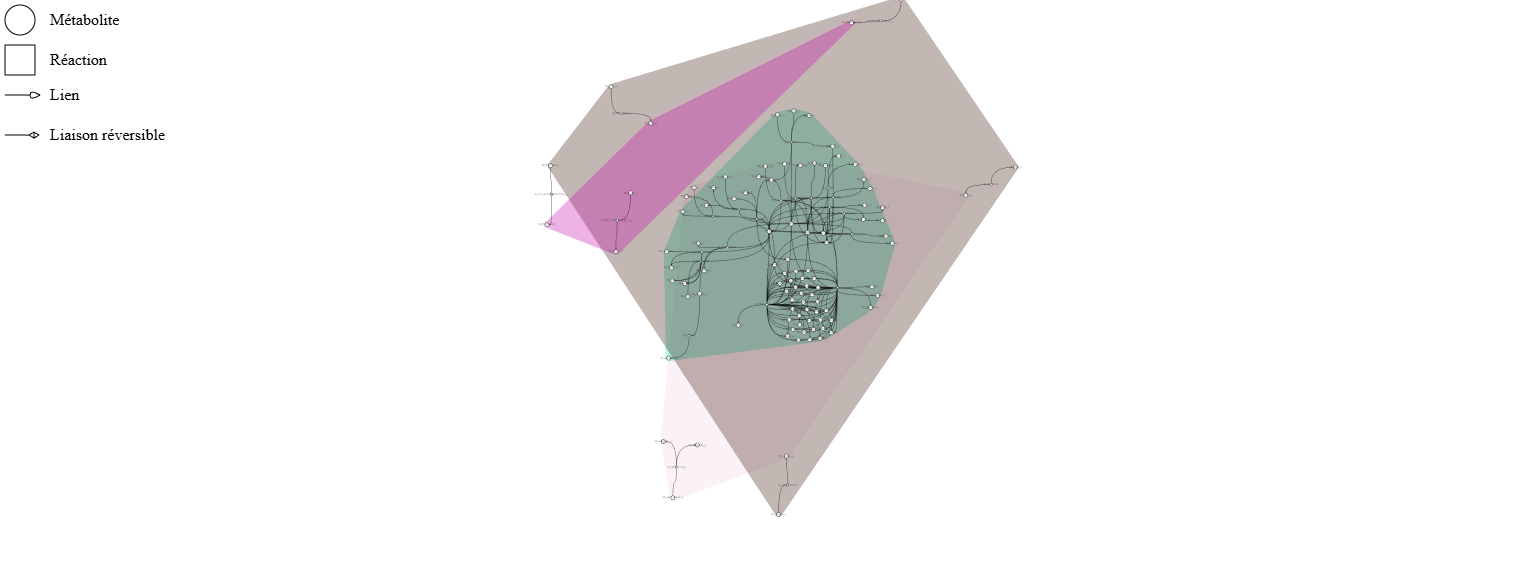

In [46]:

from IPython.display import Image, display

display(Image(filename=r"C:\Users\utilisateur\Desktop\projetmétabolisme\partie2\graph.png"))

Étape 12 : Identifier gènes essentiels

In [65]:
essential_genes = []

for gene in model.genes:
    with model:  # context manager rollback
        try:
            gene.knock_out()
            sol = model.optimize()
            # vérifier que la croissance est calculable et inférieure au seuil
            if sol.status == 'optimal' and sol.objective_value < 1e-6:
                essential_genes.append(gene.id)
        except:
            # ignorer les gènes qui posent problème
            pass

print("Nombre de gènes essentiels identifiés :", len(essential_genes))
essential_genes

Nombre de gènes essentiels identifiés : 1


['e0002']

\* Problem: Unknown *\

Maximize
 obj: + BIOMASS - BIOMASS_reverse_69053

Subject To
 r_1: - BZALDD2_reverse_3e0de + BZALDD2 = 0
 hco3_c: + AIRC2r_reverse_4ab92 - AIRC2r + PPCOAC_reverse_c6d36 - PPCOAC
 + ACCOAC_reverse_9d1cd - ACCOAC + CYNTAH_reverse_ca69d - CYNTAH
 + CBPS_reverse_80907 - CBPS - HCO3E_reverse_97ea5 + HCO3E
 + MCCC_reverse_5a395 - MCCC = 0
 murein5p4p_p: + MDDCP4pp_reverse_76a1f - MDDCP4pp
 - MDDEP3pp_reverse_99f89 + MDDEP3pp - MDDCP3pp_reverse_def42 + MDDCP3pp
 = 0
 actp_c: + ACYP_2_reverse_71a12 - ACYP_2 = 0
 r_5: - x_5380 + x_5379 - VNTDM_reverse_63a56 + VNTDM
 + PCADYOX_reverse_6fe90 - PCADYOX = 0
 glytrna_c: + 19 T3SS_E_RipI_BioS_reverse_2e7eb - 19 T3SS_E_RipI_BioS
 + 60 PROT_PglA_BioS_reverse_b3614 - 60 PROT_PglA_BioS
 + 17 T3SS_E_RipAX2_BioS_reverse_7fc1b - 17 T3SS_E_RipAX2_BioS
 + 10 T3SS_E_RipAH_BioS_reverse_e71a4 - 10 T3SS_E_RipAH_BioS
 + 141 T3SS_E_RipS3_BioS_reverse_16455 - 141 T3SS_E_RipS3_BioS
 + 50 PROT_Tek_BioS_reverse_29cfe - 50 PROT_Tek_BioS
 + 27 T3S

Le gène e0002 est indispensable à la croissance optimale et est impliqué dans la voie biomass_equation.
Cela confirme que ce gène joue un rôle central dans la synthèse de biomasse et le métabolisme cellulaire.

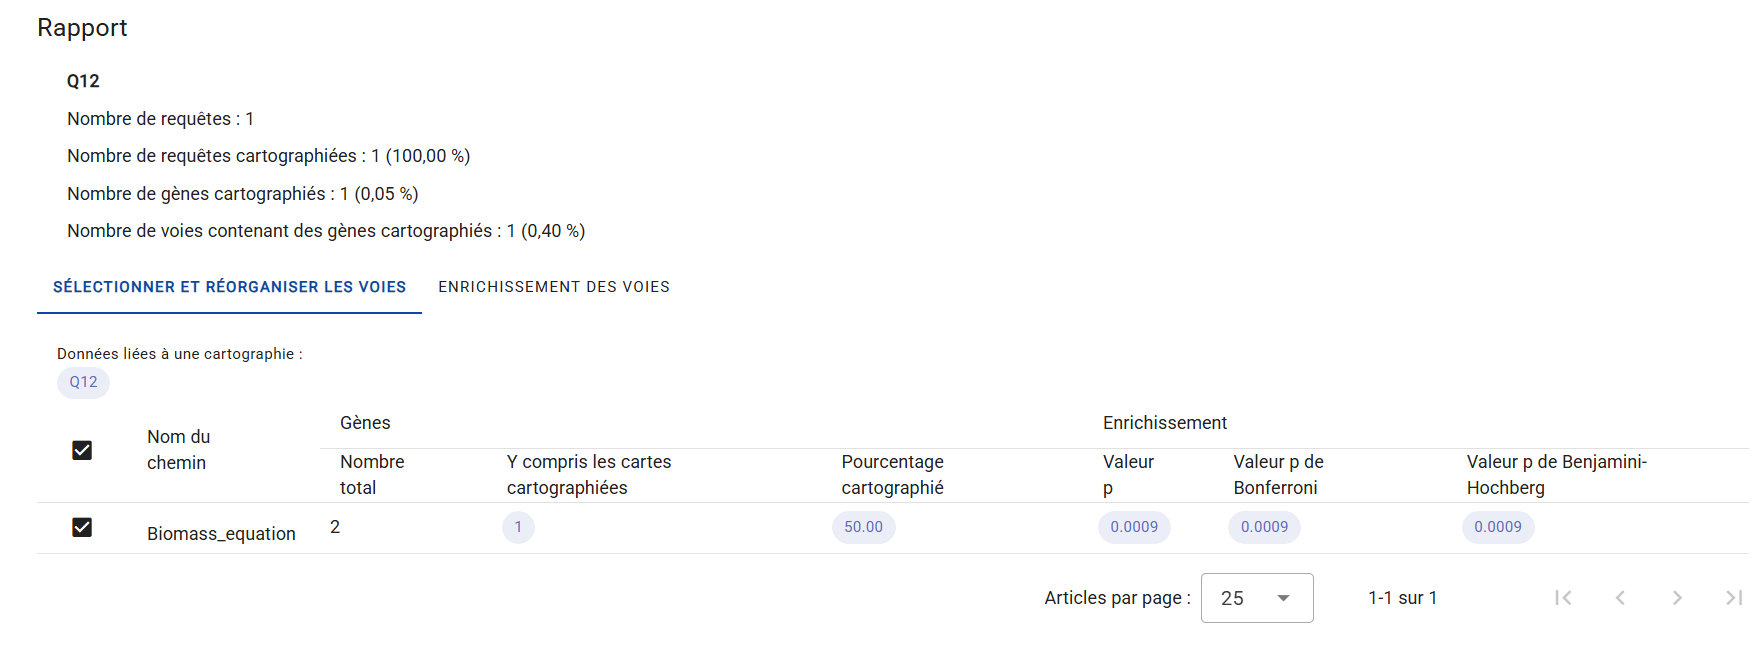

In [66]:

from IPython.display import Image, display

display(Image(filename=r"C:\Users\utilisateur\Desktop\projetmétabolisme\partie2\rapport.png"))

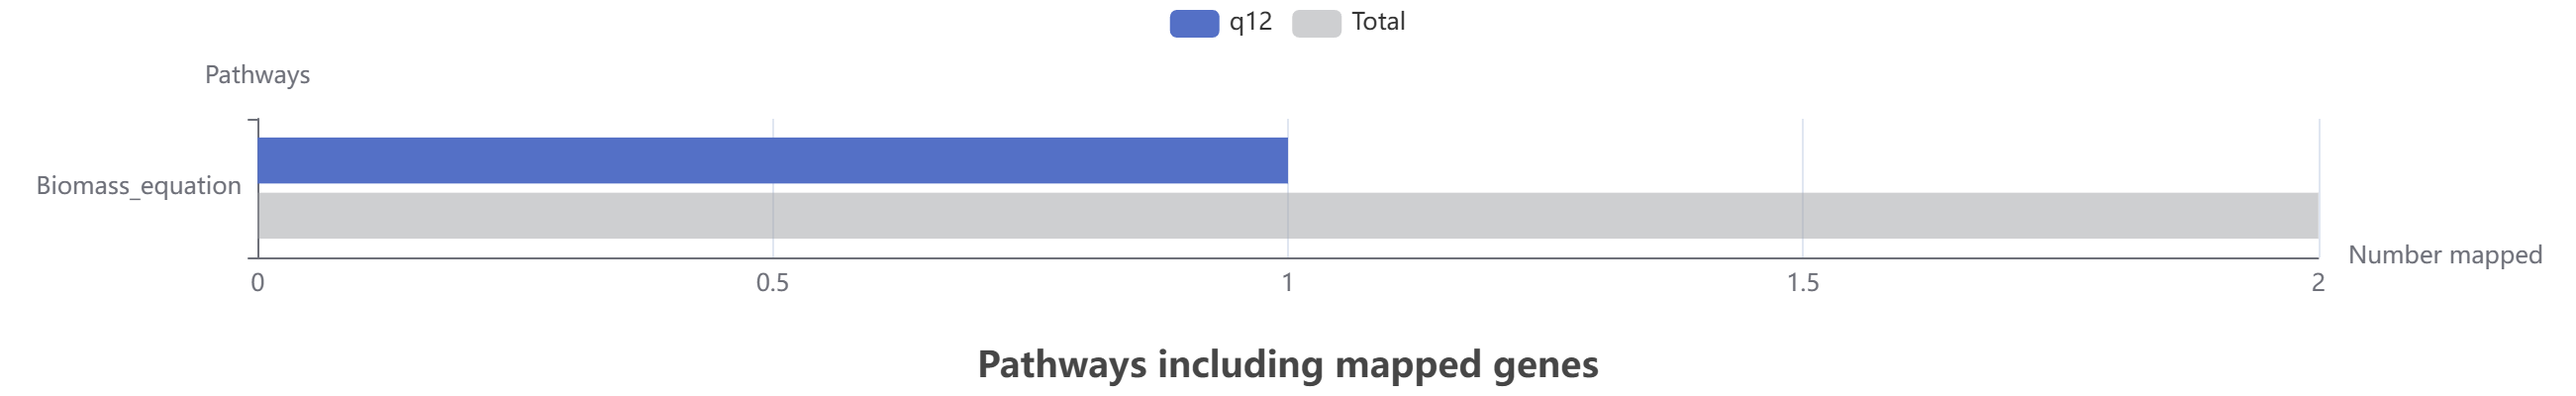

In [68]:

from IPython.display import Image, display

display(Image(filename=r"C:\Users\utilisateur\Desktop\projetmétabolisme\partie2\plot.jpg"))